In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle
import os

from tqdm import tqdm
from abc import ABC, abstractmethod

cuda_enabled = False #set to True to run on GPU
to_gpu = lambda x: x.cuda() if cuda_enabled else x
if cuda_enabled is False: print("Warning: Not running with GPU")

%matplotlib inline 

<b> Functions for computing losses </b>

In [3]:
def classification_accuracy(data_loader, model):
  total=0
  correct=0
  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = to_gpu(images), to_gpu(labels)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted==labels).sum().item()

  return correct/total

#Assumes that all batches have same size (fix?)
def total_loss(data_loader, model, loss_fn):
  total = 0
  count = 0
  with torch.no_grad():
    for x,y in data_loader:
      x,y = to_gpu(x), to_gpu(y)
      pred = model(x)
      loss = loss_fn(pred,y)
      total += loss #FIX THIS
      count += 1
  return total/count

<b> Training Methods </b>

In [4]:
#methods to calculate norms and inner products for lists of tensors

def norm_sq(v):
  return torch.sum(torch.stack([torch.norm(vi)**2 for vi in v]))

def inner_prod(v, w): #is there a better way to do this?
  return torch.sum(torch.stack([ torch.dot(torch.flatten(v_i), torch.flatten(w_i)) 
              for v_i,w_i in zip(v,w)]))

In [138]:
class Trainer(ABC):

  def __init__(self, model, criterion, trainloader, testloader):
    self.model = model
    self.criterion = criterion
    self.trainloader = trainloader
    self.testloader = testloader

    self.batch_losses = []
    self.test_class_accs = [] #classification accuracy on test data
    self.train_class_accs = [] #classification accuracy on training data
    self.total_train_losses = [] #Loss over the entire training set
    self.total_test_losses = [] #Loss over the entire testing set

    self.loss = None
    self.suppress_data = False
  
  @abstractmethod
  def do_step():
    pass

  def only_batch_data(self, flag=True):
    self.suppress_data = flag

  def update_logs(self):
    if not self.suppress_data:
      self.test_class_accs.append(classification_accuracy(self.testloader, self.model))
      self.train_class_accs.append(classification_accuracy(self.trainloader, self.model))
      self.total_train_losses.append(total_loss(self.trainloader, self.model, self.criterion))
      self.total_test_losses.append(total_loss(self.testloader,self.model, self.criterion))
      
  def train(self, n_epochs):
    for epoch in tqdm(range(n_epochs)):

      print("Epoch: ", epoch)
      self.update_logs()

      for x, y in self.trainloader:
          x, y = to_gpu(x), to_gpu(y)
          pred = self.model(x)
          self.loss = self.criterion(pred,y)
          self.batch_losses.append(self.loss.item())
          self.do_step()

    self.update_logs()

class StandardTrainer(Trainer):
  '''Used for training with Adam or SGD'''

  def __init__(self, model, criterion, trainloader, testloader, optimizer):
    super().__init__(model, criterion, trainloader, testloader)
    self.optimizer = optimizer

  def do_step(self):
    self.loss.backward()
    self.optimizer.step()
    self.optimizer.zero_grad()

class Sps2Base(Trainer):

  def __init__(self, model, criterion, trainloader, testloader, beta, step_size=1):
    super().__init__(model, criterion, trainloader, testloader)

    zero_fill = [torch.zeros_like(w_i) for w_i in self.model.parameters()]
    self.last_two_steps = [zero_fill, zero_fill] #most recent step, followed by the previous step
    self.beta = beta
    self.step_size = step_size

  #Doesn't account for the step size
  @abstractmethod
  def get_step(self):
    pass

  def update_momentum(self, step):
    self.last_two_steps[0], self.last_two_steps[1] = step, self.last_two_steps[0]

  def get_momentum(self):
    return [self.beta * (a-b) for a,b in zip(self.last_two_steps[0], self.last_two_steps[1])]

  
  def do_step(self):
    step = self.get_step()
    with torch.no_grad():
        for w_i, step_i in zip(self.model.parameters(), step):
            w_i.sub_(self.step_size * step_i) #this is where step_size is accounted for

class Sps2Trainer(Sps2Base):

  def get_step(self):
      f = self.loss
      grad_f = torch.autograd.grad(f, self.model.parameters(), create_graph=True)
      hessian_grad = torch.autograd.grad(grad_f, self.model.parameters(), grad_outputs = grad_f) #should work, but worth checking

      with torch.no_grad():
        a = f/norm_sq(grad_f)
        B = [grad_f_i - a * hessian_grad_i for grad_f_i,hessian_grad_i in zip(grad_f, hessian_grad)]
        hessgrad_grad = inner_prod(hessian_grad, grad_f)
        norm_sq_B = norm_sq(B)
        step = [a*grad_f_i + 0.5 * (a**2) * hessgrad_grad * B_i/norm_sq_B for grad_f_i,B_i in zip(grad_f, B)] #compute step separately for each layer

        self.update_momentum(step)

        inertia_term = self.get_momentum() #add on the momentum term
        for step_i, m_i in zip(step, inertia_term):
          step_i.add_(m_i)

        return step


plus = lambda x: x if x>0 else 0

class Sps2SlackTrainer(Sps2Base):

  def __init__(self, model, criterion, trainloader, testloader, lmbda, init_s, beta, step_size=1):
    super().__init__(model, criterion, trainloader, testloader, beta, step_size)
    self.lmbda = lmbda
    self.s = init_s

  def get_step(self):
    f = self.loss
    lmbda = self.lmbda
    s_t = self.s

    grad_f = torch.autograd.grad(f, self.model.parameters(), create_graph=True)
    hessian_grad = torch.autograd.grad(grad_f, self.model.parameters(), grad_outputs = grad_f) #should work, but worth checking

    with torch.no_grad():
        norm_sq_grad_f = norm_sq(grad_f)
        Gamma_1 = plus(f - (1 - lmbda)*s_t) / (1-lmbda + norm_sq_grad_f)

        Gamma_2_signed_numerator = f - Gamma_1*norm_sq_grad_f \
          + 0.5*(Gamma_1**2)*inner_prod(hessian_grad, grad_f) \
          - ((1-lmbda)**2) * (s_t + Gamma_1)

        A = [grad_f_i - Gamma_1*hessian_grad_i 
            for grad_f_i, hessian_grad_i in zip(grad_f, hessian_grad)] #comes up twice, so only compute once

        Gamma_2_denom =  1 - lmbda + norm_sq(A)
        Gamma_2 = plus(Gamma_2_signed_numerator)/Gamma_2_denom

        step = [Gamma_1 * grad_f_i + Gamma_2 * A_i for grad_f_i, A_i in zip(grad_f, A)]
        new_s = (1-lmbda)*((1-lmbda)*(s_t + Gamma_1) + Gamma_2)

        self.update_momentum(step)

        inertia_term = self.get_momentum() #add on the momentum term
        for step_i, m_i in zip(step, inertia_term):
            step_i.add_(m_i)
    
        self.s = new_s
        
    return step

<b> Load Training Data </b>

In [17]:
def load_MNIST(batch_size=50):
  transform_train = transforms.Compose([
    transforms.ToTensor()
    ,transforms.Normalize((0.1307,), (0.3081,))
  ])
  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
  ])

  train_data = torchvision.datasets.MNIST(root="./", train=True,download=True, transform=transform_train)
  test_data = torchvision.datasets.MNIST(root="./", train=False,download=True, transform=transform_test)


  trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  testloader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False)

  return trainloader, testloader

---

# **Models**

In [18]:
class Convex_Model(nn.Module):
    def __init__(self):
        super(Convex_Model, self).__init__()
        self.fc1 = nn.Linear(28*28, 10)

    def forward(self, x):
        y = x.view(x.shape[0], -1)
        y = self.fc1(y)
        return y

class Small_Model(nn.Module):
    def __init__(self):
        super(Small_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 5)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(144, 10)

    def forward(self, x):
        y = self.pool(self.relu(self.conv1(x)))
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        return y

class Medium_Model(nn.Module):
    def __init__(self):
        super(Medium_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        y = self.pool(self.relu(self.conv1(x)))
        y = self.pool(self.relu(self.conv2(y)))
        y = y.view(y.shape[0], -1)
        y = self.relu(self.fc1(y))
        y = self.relu(self.fc2(y))
        y = self.fc3(y)
        return y

class Large_Model(nn.Module):
    def __init__(self):
        super(Large_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        y = self.pool(self.relu(self.conv1(x)))
        y = self.pool(self.relu(self.conv2(y)))

        y = y.view(y.shape[0], -1)
        y = self.relu(self.fc1(y))
        y = self.relu(self.fc2(y))
        y = self.fc3(y)
        return y

In [19]:
def num_trainable_params(model):
  return np.sum( [np.prod(p.size()) for p in model.parameters()])

In [20]:
print("Convex params: ", num_trainable_params(Convex_Model()))

print("Small params: ", num_trainable_params(Small_Model()))
print("Medium params: ", num_trainable_params(Medium_Model()))
print("Large params: ", num_trainable_params(Large_Model()))

Convex params:  7850
Small params:  1476
Medium params:  44426
Large params:  331594


<b> Experiment Boilerplate </b>

In [21]:
def save_data_as(trainer, name, info):
    
    path = './experiments/' + name
    try:
        os.mkdir(path)
    except: #folder already exists
        pass
    
    items = [trainer.batch_losses, trainer.test_class_accs, trainer.train_class_accs,
            trainer.total_train_losses, trainer.total_test_losses, trainer.model]
    filenames = ["batch_losses", "test_class_accs", "train_class_accs",
            "total_train_losses", "total_test_losses", "model"]
    for item, filename in zip(items, filenames):
        pickle.dump( item, open( path + "/" + filename + ".pkl", "wb" ) )
    
    with open(path + "/info.txt", "w") as info_file:
        info_file.write(info)

        
def load_data(name, return_model=False):
    path = './experiments/' + name
    filenames = ["batch_losses", "test_class_accs", "train_class_accs",
                "total_train_losses", "total_test_losses"]
    
    data = {}
    for filename in filenames:
        data[filename] = pickle.load( open( path + "/" + filename + ".pkl", "rb" ) )
    
    if return_model:
        model = pickle.load( open( path + "/" + "model" + ".pkl", "rb" ) )
        return data, model
    else:
        return data

def run_and_save_MNIST(exp_name, opt_method, model_size, n_epochs, method_kwargs, batch_size=50, rand_seed=0):
    
    torch.manual_seed(rand_seed)

    if model_size == "small":
        model = to_gpu(Small_Model())
    elif model_size == "medium":
        model = to_gpu(Medium_Model())
    elif model_size == "large":
        model = to_gpu(Large_Model())
    elif model_size == "convex":
        model = to_gpu(Convex_Model())
    else:
        assert(False)
        
    trainloader, testloader = load_MNIST(batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    
    if opt_method == "sps2":
        trainer = Sps2Trainer(model, criterion, trainloader, testloader, **method_kwargs)
    elif opt_method == "sps2slack":
        trainer = Sps2SlackTrainer(model, criterion, trainloader, testloader, **method_kwargs)
    elif opt_method == "adam":
        optimizer = torch.optim.Adam(model.parameters(), **method_kwargs)
        trainer = StandardTrainer(model, criterion, trainloader, testloader, optimizer = optimizer) 
    else:
        assert(False)
        
    trainer.train(n_epochs)
    
    info = "data: MNIST" + \
        "\nmethod: " + opt_method + \
        "\nmodel size: " + model_size + \
        "\nepochs: " + str(n_epochs) + \
        "\nbatch size: " + str(batch_size) + \
        "\nargs: " + str(method_kwargs) + \
        "\nseed: " + str(rand_seed)
    
    save_data_as(trainer, exp_name, info)

# **Run Experiments**

<b> Adam Experiments </b>

In [53]:
adam_lr = 0.01
adam_epochs = 10
adam_batch_size = 50


adam_convex = {
    'exp_name':      "adam_convex",
    'opt_method':    "adam",
    'method_kwargs': {'lr': adam_lr},
    'model_size':    "convex",
    'n_epochs':      adam_epochs,
    'batch_size':    adam_batch_size,
    'rand_seed':     0 
}

adam_small = {
    'exp_name':      "adam_small",
    'opt_method':    "adam",
    'method_kwargs': {'lr': adam_lr},
    'model_size':    "small",
    'n_epochs':      adam_epochs,
    'batch_size':    adam_batch_size,
    'rand_seed':     0 
}

adam_medium = {
    'exp_name':      "adam_medium",
    'opt_method':    "adam",
    'method_kwargs': {'lr': adam_lr},
    'model_size':    "medium",
    'n_epochs':      adam_epochs,
    'batch_size':    adam_batch_size,
    'rand_seed':     0 
}

adam_large = {
    'exp_name':      "adam_large",
    'opt_method':    "adam",
    'method_kwargs': {'lr': adam_lr},
    'model_size':    "small",
    'n_epochs':      adam_epochs,
    'batch_size':    adam_batch_size,
    'rand_seed':     0 
}

In [54]:
run_and_save_MNIST(**adam_small)

Epoch:  0


100%|██████████| 1200/1200 [00:14<00:00, 80.18it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:14<00:00, 82.02it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:14<00:00, 80.06it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:15<00:00, 79.88it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:15<00:00, 79.57it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:15<00:00, 79.67it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:14<00:00, 80.47it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:14<00:00, 82.63it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:15<00:00, 78.65it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:14<00:00, 80.64it/s]


In [59]:
run_and_save_MNIST(**adam_medium)

Epoch:  0


100%|██████████| 1200/1200 [00:19<00:00, 60.12it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:20<00:00, 58.85it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:21<00:00, 56.30it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:20<00:00, 57.82it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:20<00:00, 59.24it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:20<00:00, 59.44it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:20<00:00, 58.91it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:21<00:00, 55.19it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:20<00:00, 57.34it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:20<00:00, 57.31it/s]


In [ ]:
run_and_save_MNIST(**adam_large)

<b> Sps2 </b>

In [65]:
sps2_epochs = 10
sps2_batch_size = 50

sps2_small = {
    'exp_name':      "sps2_small",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.01},
    'model_size':    "small",
    'n_epochs':      sps2_epochs,
    'batch_size':    sps2_batch_size,
    'rand_seed':     0 
}

sps2_medium = {
    'exp_name':      "sps2_medium",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.01},
    'model_size':    "medium",
    'n_epochs':      sps2_epochs,
    'batch_size':    sps2_batch_size,
    'rand_seed':     0 
}

sps2_large = {
    'exp_name':      "sps2_large",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.01},
    'model_size':    "large",
    'n_epochs':      sps2_epochs,
    'batch_size':    sps2_batch_size,
    'rand_seed':     0 
}

In [11]:
sps2_epochs = 10
sps2_batch_size = 50

sps2_small_large_mom = {
    'exp_name':      "sps2_small_large_mom",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.1},
    'model_size':    "small",
    'n_epochs':      sps2_epochs,
    'batch_size':    sps2_batch_size,
    'rand_seed':     0 
}

sps2_medium_large_mom = {
    'exp_name':      "sps2_medium_large_mom",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.1},
    'model_size':    "medium",
    'n_epochs':      sps2_epochs,
    'batch_size':    sps2_batch_size,
    'rand_seed':     0 
}

sps2_large_small_mom = {
    'exp_name':      "sps2_large",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.1},
    'model_size':    "large",
    'n_epochs':      sps2_epochs,
    'batch_size':    sps2_batch_size,
    'rand_seed':     0 
}

In [13]:
run_and_save_MNIST(**sps2_small_large_mom)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Epoch:  0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 1200/1200 [00:25<00:00, 47.68it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:23<00:00, 50.99it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:23<00:00, 50.94it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:24<00:00, 49.96it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:23<00:00, 51.29it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:23<00:00, 50.50it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:25<00:00, 46.55it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:26<00:00, 45.12it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:24<00:00, 49.22it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:27<00:00, 43.15it/s]


In [14]:
run_and_save_MNIST(**sps2_medium_large_mom)

Epoch:  0


100%|██████████| 1200/1200 [00:42<00:00, 28.47it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:42<00:00, 28.27it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:43<00:00, 27.67it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:43<00:00, 27.77it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:44<00:00, 27.10it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:44<00:00, 27.20it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:42<00:00, 28.18it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:43<00:00, 27.48it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:44<00:00, 27.07it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:42<00:00, 28.37it/s]


In [ ]:
run_and_save_MNIST(**sps2_large)

<b> Sps2 Slack </b>

In [69]:
sps2slack_epochs = 10
sps2slack_batch_size = 50

sps2slack_small = {
    'exp_name':      "sps2slack_small",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01}, #beta might be too small
    'model_size':    "small",
    'n_epochs':      sps2slack_epochs,
    'batch_size':    sps2slack_batch_size,
    'rand_seed':     0 
}

sps2slack_medium = {
    'exp_name':      "sps2slack_medium",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01},
    'model_size':    "medium",
    'n_epochs':      sps2slack_epochs,
    'batch_size':    sps2slack_batch_size,
    'rand_seed':     0 
}

sps2slack_large = {
    'exp_name':      "sps2slack_large",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01},
    'model_size':    "large",
    'n_epochs':      sps2slack_epochs,
    'batch_size':    sps2slack_batch_size,
    'rand_seed':     0 
}

In [ ]:
run_and_save_MNIST(**sps2slack_small)

In [70]:
run_and_save_MNIST(**sps2slack_medium)

Epoch:  0


100%|██████████| 1200/1200 [00:40<00:00, 29.62it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:40<00:00, 29.69it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:40<00:00, 29.87it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:40<00:00, 29.82it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:39<00:00, 30.01it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:40<00:00, 29.45it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:40<00:00, 29.67it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:40<00:00, 29.58it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:39<00:00, 30.48it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:39<00:00, 30.09it/s]


In [ ]:
run_and_save_MNIST(**sps2slack_large)

<b> Varying step sizes </b>

In [102]:
epochs = 10
batch_size = 50

#### Small Model ######
sps2_small_small_stepsize = {
    'exp_name':      "small_stepsize_0.1",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.5, 'step_size':0.1},
    'model_size':    "small",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2_small_med_stepsize = {
    'exp_name':      "small_stepsize_0.5",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.5, 'step_size':0.5},
    'model_size':    "small",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2_small_large_stepsize = {
    'exp_name':      "small_stepsize_1",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.5, 'step_size':1.0},
    'model_size':    "small",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

#### Medium Model ####

sps2_med_small_stepsize = {
    'exp_name':      "med_stepsize_0.1",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.5, 'step_size':0.1},
    'model_size':    "medium",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2_med_med_stepsize = {
    'exp_name':      "med_stepsize_0.5",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.5, 'step_size':0.5},
    'model_size':    "medium",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2_med_large_stepsize = {
    'exp_name':      "large_stepsize_1",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.5, 'step_size':1},
    'model_size':    "medium",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

#### Large Model ####

sps2_large_small_stepsize = {
    'exp_name':      "large_stepsize_0.1",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.5, 'step_size':0.1},
    'model_size':    "large",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2_large_med_stepsize = {
    'exp_name':      "large_stepsize_0.5",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.5, 'step_size':0.5},
    'model_size':    "large",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2_large_large_stepsize = {
    'exp_name':      "large_stepsize_1",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.5, 'step_size':1},
    'model_size':    "large",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

### 'Convex' model#######

sps2_convex_small_stepsize = {
    'exp_name':      "convex_stepsize_0.1",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.5, 'step_size':0.1},
    'model_size':    "convex",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2_convex_med_stepsize = {
    'exp_name':      "convex_stepsize_0.5",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.5, 'step_size':0.5},
    'model_size':    "convex",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2_convex_large_stepsize = {
    'exp_name':      "convex_stepsize_1",
    'opt_method':    "sps2",
    'method_kwargs': {'beta': 0.5, 'step_size':1.0},
    'model_size':    "convex",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

In [51]:
run_and_save_MNIST(**sps2_small_small_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:21<00:00, 56.36it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:21<00:00, 55.28it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:23<00:00, 51.08it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:22<00:00, 52.92it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:22<00:00, 52.67it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:22<00:00, 52.91it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:23<00:00, 51.87it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:22<00:00, 52.70it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:22<00:00, 52.48it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:24<00:00, 48.39it/s]


In [46]:
run_and_save_MNIST(**sps2_small_med_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:21<00:00, 56.35it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:21<00:00, 55.88it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:21<00:00, 56.39it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:21<00:00, 56.41it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:21<00:00, 56.20it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:21<00:00, 55.65it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:21<00:00, 55.95it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:21<00:00, 55.67it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:22<00:00, 54.52it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:21<00:00, 55.16it/s]


In [52]:
run_and_save_MNIST(**sps2_small_large_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:21<00:00, 55.46it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:21<00:00, 56.17it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:21<00:00, 56.27it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:21<00:00, 56.61it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:21<00:00, 54.69it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:21<00:00, 56.10it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:21<00:00, 54.86it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:21<00:00, 56.16it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:21<00:00, 55.72it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:21<00:00, 55.53it/s]


In [40]:
run_and_save_MNIST(**sps2_med_small_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:44<00:00, 27.12it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:39<00:00, 30.19it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:39<00:00, 30.07it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:39<00:00, 30.35it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:39<00:00, 30.33it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:40<00:00, 29.80it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:39<00:00, 30.34it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:39<00:00, 30.53it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:40<00:00, 29.75it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:40<00:00, 29.95it/s]


In [55]:
run_and_save_MNIST(**sps2_med_med_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:40<00:00, 29.67it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:39<00:00, 30.08it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:39<00:00, 30.76it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:41<00:00, 29.05it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:39<00:00, 30.25it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:39<00:00, 30.74it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:39<00:00, 30.39it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:39<00:00, 30.70it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:39<00:00, 30.55it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:39<00:00, 30.25it/s]


In [56]:
run_and_save_MNIST(**sps2_med_large_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:39<00:00, 30.70it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:39<00:00, 30.67it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:39<00:00, 30.41it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:39<00:00, 30.08it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:39<00:00, 30.46it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:39<00:00, 30.26it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:39<00:00, 30.46it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:39<00:00, 30.63it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:39<00:00, 30.63it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:39<00:00, 30.54it/s]


In [43]:
run_and_save_MNIST(**sps2_large_small_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [02:25<00:00,  8.23it/s]


Epoch:  1


100%|██████████| 1200/1200 [02:26<00:00,  8.17it/s]


Epoch:  2


100%|██████████| 1200/1200 [02:25<00:00,  8.24it/s]


Epoch:  3


100%|██████████| 1200/1200 [02:27<00:00,  8.14it/s]


Epoch:  4


100%|██████████| 1200/1200 [02:27<00:00,  8.13it/s]


Epoch:  5


100%|██████████| 1200/1200 [02:27<00:00,  8.14it/s]


Epoch:  6


100%|██████████| 1200/1200 [02:28<00:00,  8.09it/s]


Epoch:  7


100%|██████████| 1200/1200 [02:25<00:00,  8.23it/s]


Epoch:  8


100%|██████████| 1200/1200 [02:25<00:00,  8.24it/s]


Epoch:  9


100%|██████████| 1200/1200 [02:25<00:00,  8.25it/s]


In [57]:
run_and_save_MNIST(**sps2_large_med_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [02:29<00:00,  8.04it/s]


Epoch:  1


100%|██████████| 1200/1200 [02:27<00:00,  8.14it/s]


Epoch:  2


100%|██████████| 1200/1200 [02:30<00:00,  7.95it/s]


Epoch:  3


100%|██████████| 1200/1200 [02:26<00:00,  8.17it/s]


Epoch:  4


100%|██████████| 1200/1200 [02:26<00:00,  8.20it/s]


Epoch:  5


100%|██████████| 1200/1200 [02:26<00:00,  8.21it/s]


Epoch:  6


100%|██████████| 1200/1200 [02:28<00:00,  8.11it/s]


Epoch:  7


100%|██████████| 1200/1200 [02:31<00:00,  7.90it/s]


Epoch:  8


100%|██████████| 1200/1200 [02:28<00:00,  8.10it/s]


Epoch:  9


100%|██████████| 1200/1200 [02:27<00:00,  8.15it/s]


In [58]:
run_and_save_MNIST(**sps2_large_large_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [02:24<00:00,  8.29it/s]


Epoch:  1


100%|██████████| 1200/1200 [02:24<00:00,  8.33it/s]


Epoch:  2


100%|██████████| 1200/1200 [02:25<00:00,  8.25it/s]


Epoch:  3


100%|██████████| 1200/1200 [02:24<00:00,  8.30it/s]


Epoch:  4


100%|██████████| 1200/1200 [02:24<00:00,  8.29it/s]


Epoch:  5


100%|██████████| 1200/1200 [02:26<00:00,  8.20it/s]


Epoch:  6


100%|██████████| 1200/1200 [02:32<00:00,  7.87it/s]


Epoch:  7


100%|██████████| 1200/1200 [02:36<00:00,  7.68it/s]


Epoch:  8


100%|██████████| 1200/1200 [02:34<00:00,  7.76it/s]


Epoch:  9


100%|██████████| 1200/1200 [02:31<00:00,  7.90it/s]


In [103]:
run_and_save_MNIST(**sps2_convex_small_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:10<00:00, 114.16it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:10<00:00, 112.63it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:10<00:00, 113.77it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:11<00:00, 104.09it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:10<00:00, 113.26it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:10<00:00, 110.70it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:10<00:00, 113.58it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:11<00:00, 104.40it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:11<00:00, 106.03it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:11<00:00, 106.21it/s]


In [104]:
run_and_save_MNIST(**sps2_convex_med_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:10<00:00, 113.04it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:11<00:00, 106.99it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:10<00:00, 109.38it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:10<00:00, 112.68it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:10<00:00, 112.88it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:10<00:00, 112.12it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:10<00:00, 111.82it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:11<00:00, 107.15it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:11<00:00, 107.27it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:10<00:00, 111.78it/s]


In [105]:
run_and_save_MNIST(**sps2_convex_large_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:10<00:00, 112.08it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:10<00:00, 111.88it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:10<00:00, 112.01it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:10<00:00, 110.10it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:11<00:00, 108.72it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:11<00:00, 105.10it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:11<00:00, 107.74it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:11<00:00, 105.31it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:11<00:00, 108.28it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:10<00:00, 109.09it/s]


<b> With Slack </b>

In [136]:
epochs = 10
batch_size = 50

#### Small Model ######
sps2slack_small_small_stepsize = {
    'exp_name':      "slack_small_stepsize_0.1",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01},
    'model_size':    "small",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2slack_small_med_stepsize = {
    'exp_name':      "slack_small_stepsize_0.5",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01},
    'model_size':    "small",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2slack_small_large_stepsize = {
    'exp_name':      "slack_small_stepsize_1",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01},
    'model_size':    "small",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

#### Medium Model ####

sps2slack_med_small_stepsize = {
    'exp_name':      "slack_med_stepsize_0.1",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01},
    'model_size':    "medium",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2slack_med_med_stepsize = {
    'exp_name':      "slack_med_stepsize_0.5",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01},
    'model_size':    "medium",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2slack_med_large_stepsize = {
    'exp_name':      "slack_large_stepsize_1",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01},
    'model_size':    "medium",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

#### Large Model ####

sps2slack_large_small_stepsize = {
    'exp_name':      "slack_large_stepsize_0.1",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01},
    'model_size':    "large",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2slack_large_med_stepsize = {
    'exp_name':      "slack_large_stepsize_0.5",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01},
    'model_size':    "large",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2slack_large_large_stepsize = {
    'exp_name':      "slack_large_stepsize_1",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01},
    'model_size':    "large",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

#### Convex Model ####

sps2slack_convex_small_stepsize = {
    'exp_name':      "slack_convex_stepsize_0.1",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01},
    'model_size':    "convex",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2slack_convex_med_stepsize = {
    'exp_name':      "slack_convex_stepsize_0.5",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01},
    'model_size':    "convex",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

sps2slack_convex_large_stepsize = {
    'exp_name':      "slack_convex_stepsize_1",
    'opt_method':    "sps2slack",
    'method_kwargs': {'lmbda':0.5, 'init_s':1, 'beta':0.01},
    'model_size':    "convex",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}


In [95]:
run_and_save_MNIST(**sps2slack_small_small_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:22<00:00, 54.45it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:22<00:00, 53.66it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:22<00:00, 54.49it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:22<00:00, 53.86it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:21<00:00, 56.49it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:22<00:00, 53.61it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:21<00:00, 55.32it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:21<00:00, 55.49it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:21<00:00, 55.21it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:21<00:00, 55.38it/s]


In [96]:
run_and_save_MNIST(**sps2slack_small_med_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:21<00:00, 55.77it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:21<00:00, 55.83it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:21<00:00, 55.31it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:21<00:00, 55.29it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:21<00:00, 55.82it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:21<00:00, 54.61it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:21<00:00, 55.04it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:22<00:00, 54.03it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:23<00:00, 51.73it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:22<00:00, 52.31it/s]


In [97]:
run_and_save_MNIST(**sps2slack_small_large_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:22<00:00, 53.08it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:22<00:00, 52.98it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:22<00:00, 54.33it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:23<00:00, 51.72it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:22<00:00, 54.36it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:22<00:00, 52.26it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:22<00:00, 53.62it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:22<00:00, 53.60it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:22<00:00, 53.81it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:23<00:00, 50.96it/s]


In [98]:
run_and_save_MNIST(**sps2slack_med_small_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:38<00:00, 30.84it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:39<00:00, 30.41it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:42<00:00, 28.14it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:39<00:00, 30.14it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:42<00:00, 28.52it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:41<00:00, 29.02it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:38<00:00, 30.78it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:40<00:00, 29.99it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:41<00:00, 28.72it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:41<00:00, 28.93it/s]


In [99]:
run_and_save_MNIST(**sps2slack_med_med_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:40<00:00, 29.41it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:40<00:00, 29.36it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:41<00:00, 28.92it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:38<00:00, 31.03it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:39<00:00, 30.56it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:40<00:00, 29.33it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:40<00:00, 29.50it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:41<00:00, 28.84it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:41<00:00, 29.06it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:40<00:00, 29.28it/s]


In [100]:
run_and_save_MNIST(**sps2slack_med_large_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:41<00:00, 29.19it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:40<00:00, 29.60it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:41<00:00, 28.80it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:41<00:00, 28.85it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:41<00:00, 28.93it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:40<00:00, 29.30it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:40<00:00, 29.32it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:41<00:00, 28.95it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:39<00:00, 30.35it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:39<00:00, 30.23it/s]


In [101]:
run_and_save_MNIST(**sps2slack_large_small_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [02:29<00:00,  8.03it/s]


Epoch:  1


100%|██████████| 1200/1200 [02:28<00:00,  8.06it/s]


Epoch:  2


100%|██████████| 1200/1200 [02:26<00:00,  8.22it/s]


Epoch:  3


100%|██████████| 1200/1200 [02:26<00:00,  8.17it/s]


Epoch:  4


100%|██████████| 1200/1200 [02:29<00:00,  8.00it/s]


Epoch:  5


100%|██████████| 1200/1200 [02:28<00:00,  8.06it/s]


Epoch:  6


100%|██████████| 1200/1200 [02:25<00:00,  8.24it/s]


Epoch:  7


100%|██████████| 1200/1200 [02:26<00:00,  8.21it/s]


Epoch:  8


100%|██████████| 1200/1200 [02:29<00:00,  8.03it/s]


Epoch:  9


100%|██████████| 1200/1200 [02:32<00:00,  7.88it/s]


In [ ]:
run_and_save_MNIST(**sps2slack_large_med_stepsize)

In [ ]:
run_and_save_MNIST(**sps2slack_large_large_stepsize)

In [137]:
run_and_save_MNIST(**sps2slack_convex_small_stepsize)

Epoch:  0


100%|██████████| 1200/1200 [00:12<00:00, 98.73it/s] 


Epoch:  1


100%|██████████| 1200/1200 [00:11<00:00, 102.10it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:10<00:00, 111.81it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:11<00:00, 108.00it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:11<00:00, 104.43it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:11<00:00, 106.13it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:11<00:00, 107.42it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:11<00:00, 107.69it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:10<00:00, 112.15it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:10<00:00, 112.20it/s]


In [ ]:
run_and_save_MNIST(**sps2slack_convex_med_stepsize)

In [ ]:
run_and_save_MNIST(**sps2slack_convex_lage_stepsize)

<b> Adam </b>

In [108]:
epochs = 10
batch_size = 50

#### Small Model ######
adam_small = {
    'exp_name':      "adam_small",
    'opt_method':    "adam",
    'method_kwargs': {},
    'model_size':    "small",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

#### Medium Model ####

adam_med = {
    'exp_name':      "adam_med",
    'opt_method':    "adam",
    'method_kwargs': {},
    'model_size':    "medium",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

#### Large Model ####

adam_large = {
    'exp_name':      "adam_large",
    'opt_method':    "adam",
    'method_kwargs': {},
    'model_size':    "large",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

#### Convex Model ####

adam_convex = {
    'exp_name':      "adam_convex",
    'opt_method':    "adam",
    'method_kwargs': {},
    'model_size':    "convex",
    'n_epochs':      epochs,
    'batch_size':    batch_size,
    'rand_seed':     0 
}

In [109]:
run_and_save_MNIST(**adam_small)

Epoch:  0


100%|██████████| 1200/1200 [00:15<00:00, 77.75it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:15<00:00, 77.91it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:14<00:00, 80.45it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:14<00:00, 80.06it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:14<00:00, 80.23it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:14<00:00, 80.86it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:15<00:00, 79.74it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:14<00:00, 81.29it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:14<00:00, 81.27it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:14<00:00, 80.15it/s]


In [110]:
run_and_save_MNIST(**adam_med)

Epoch:  0


100%|██████████| 1200/1200 [00:20<00:00, 59.49it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:20<00:00, 58.94it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:20<00:00, 59.35it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:20<00:00, 59.35it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:20<00:00, 59.56it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:20<00:00, 58.93it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:21<00:00, 56.06it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:20<00:00, 57.52it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:20<00:00, 57.56it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:20<00:00, 57.39it/s]


In [111]:
run_and_save_MNIST(**adam_large)

Epoch:  0


100%|██████████| 1200/1200 [00:54<00:00, 22.22it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:53<00:00, 22.27it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:52<00:00, 22.74it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:52<00:00, 22.80it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:52<00:00, 22.70it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:52<00:00, 22.68it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:52<00:00, 22.86it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:52<00:00, 22.75it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:52<00:00, 22.65it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:52<00:00, 22.96it/s]


In [112]:
run_and_save_MNIST(**adam_convex)

Epoch:  0


100%|██████████| 1200/1200 [00:11<00:00, 100.06it/s]


Epoch:  1


100%|██████████| 1200/1200 [00:10<00:00, 110.52it/s]


Epoch:  2


100%|██████████| 1200/1200 [00:10<00:00, 113.33it/s]


Epoch:  3


100%|██████████| 1200/1200 [00:10<00:00, 113.09it/s]


Epoch:  4


100%|██████████| 1200/1200 [00:10<00:00, 110.05it/s]


Epoch:  5


100%|██████████| 1200/1200 [00:10<00:00, 117.95it/s]


Epoch:  6


100%|██████████| 1200/1200 [00:10<00:00, 113.62it/s]


Epoch:  7


100%|██████████| 1200/1200 [00:10<00:00, 113.52it/s]


Epoch:  8


100%|██████████| 1200/1200 [00:10<00:00, 119.86it/s]


Epoch:  9


100%|██████████| 1200/1200 [00:10<00:00, 113.69it/s]


# **Figures**

In [88]:
def MA(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def make_exp_plot(exp_name):
    data = load_data(exp_name)
    plt.ylabel('batch loss')
    #plt.plot( data['batch_losses'],'.',markersize=1 )
    #plt.plot(MA(data['total_test_losses'],100))
    plt.plot(data['total_train_losses'])

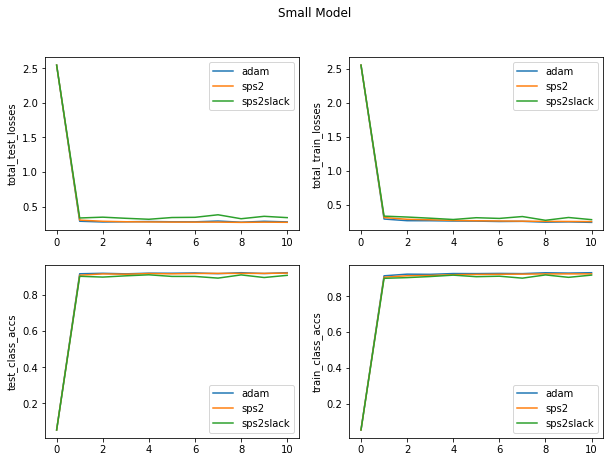

In [180]:
#plt.title('Small Model')

fig, ax = plt.subplots(2, 2, figsize=(10,7))

fig.suptitle('Small Model')

#exps =  ['adam_small', 'small_stepsize_0.1', 'slack_small_stepsize_0.1']
#exps =  ['adam_med', 'med_stepsize_0.1', 'slack_med_stepsize_0.1']
#exps =  ['adam_large', 'large_stepsize_0.1', 'slack_large_stepsize_0.1']
exps =  ['adam_convex', 'convex_stepsize_0.1', 'slack_convex_stepsize_0.1']



labels = ['adam', 'sps2', 'sps2slack']
subfigs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]
data_types = ['total_test_losses', 'total_train_losses', 'test_class_accs', 'train_class_accs']

for data_type, subfig in zip(data_types,subfigs):
    for exp_name,label in zip(exps,labels):
        data = load_data(exp_name)
        subfig.plot(data[data_type], label=label)
        subfig.set_ylabel(data_type)
        subfig.legend()
    
plt.show()

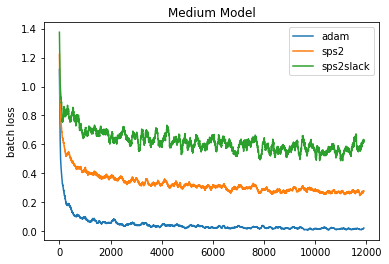

In [146]:
exps =  ['adam_med', 'med_stepsize_0.1', 'slack_med_stepsize_0.1']
labels = ['adam', 'sps2', 'sps2slack']



plt.title('Medium Model')

for exp_name,label in zip(exps,labels):
    data = load_data(exp_name)
    plt.plot(MA(data['batch_losses'],100), label=label)
    plt.ylabel('batch loss')

plt.legend()
plt.show()

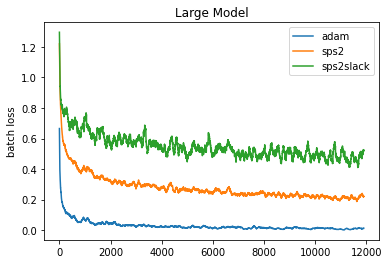

In [147]:
exps =  ['adam_large', 'large_stepsize_0.1', 'slack_large_stepsize_0.1']
labels = ['adam', 'sps2', 'sps2slack']

plt.title('Large Model')

for exp_name,label in zip(exps,labels):
    data = load_data(exp_name)
    plt.plot(MA(data['batch_losses'],100), label=label)
    plt.ylabel('batch loss')

plt.legend()
plt.show()

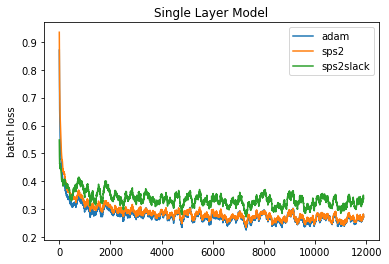

In [150]:
exps =  ['adam_convex', 'convex_stepsize_0.1', 'slack_convex_stepsize_0.1']
labels = ['adam', 'sps2', 'sps2slack']

plt.title('Single Layer Model')

for exp_name,label in zip(exps,labels):
    data = load_data(exp_name)
    plt.plot(MA(data['batch_losses'],100), label=label)
    plt.ylabel('batch loss')

plt.legend()
plt.show()

<b> Adam </b>

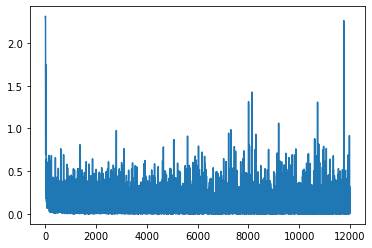

In [60]:
adam_data = load_data("adam_medium")
plt.plot(adam_data['batch_losses'])
plt.show()

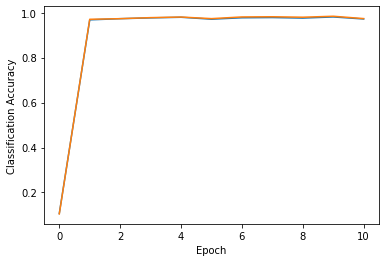

In [61]:
plt.xlabel('Epoch')
plt.ylabel('Classification Accuracy')
plt.plot(adam_data['test_class_accs'])
plt.plot(adam_data['train_class_accs'])
plt.show()

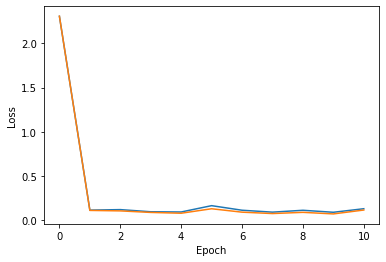

In [64]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(adam_data['total_test_losses'])
plt.plot(adam_data['total_train_losses'])
plt.show()

<b> SPS-2 </b>

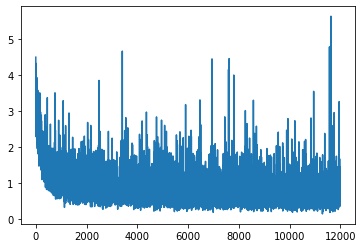

In [77]:
sps2_data = load_data("sps2_medium")
plt.plot(sps2_data['batch_losses'][5:])
plt.show()

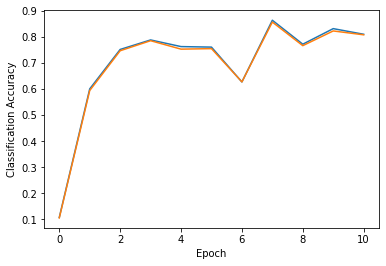

In [78]:
plt.xlabel('Epoch')
plt.ylabel('Classification Accuracy')
plt.plot(sps2_data['test_class_accs'])
plt.plot(sps2_data['train_class_accs'])
plt.show()

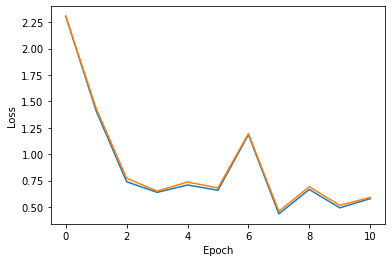

In [80]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(sps2_data['total_test_losses'])
plt.plot(sps2_data['total_train_losses'])
plt.show()

<b> SPS-2 Slack </b>

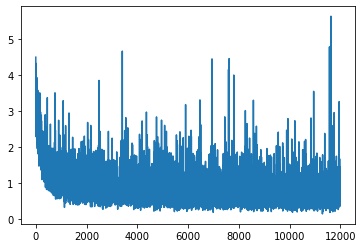

In [83]:
sps2slack_data = load_data("sps2slack_medium")
plt.plot(adam_data['batch_losses'][5:])
plt.show()

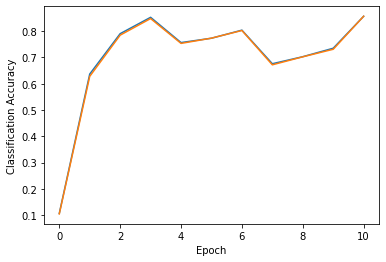

In [84]:
plt.xlabel('Epoch')
plt.ylabel('Classification Accuracy')
plt.plot(sps2slack_data['test_class_accs'])
plt.plot(sps2slack_data['train_class_accs'])
plt.show()

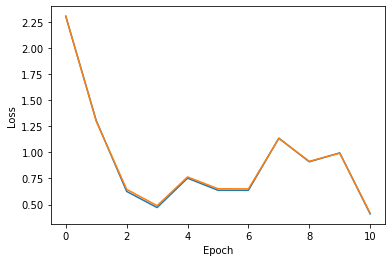

In [85]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(sps2slack_data['total_test_losses'])
plt.plot(sps2slack_data['total_train_losses'])
plt.show()

In [ ]:
sps_large_mom = load_data("sps2slack_medium_large_mom")
plt.plot(sps_large_mom['batch_losses'][5:])
plt.show()